## import package and data

In [ ]:
# Install package first
# We use uv for faster installation

# Google Colab is setting some uv-related environment variables, that seem to have broken with the a Colab update.
# The Colab team is tracking this internally (googlecolab/colabtools#5237).
# https://github.com/googlecolab/colabtools/issues/5237#issuecomment-2786440777
import os
os.environ["UV_CONSTRAINT"] = os.environ["UV_BUILD_CONSTRAINT"] = ""  # add this line to solve the uv related issue

!pip install uv
!uv pip install -q autogluon.timeseries --system --prerelease allow
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab
!uv pip uninstall transformers
# !uv pip install -q torch==2.3.0 torchvision==0.18.0 --index-url https://download.pytorch.org/whl/cu118
!uv pip install -q transformers==4.44.2

Using Python 3.11.12 environment at: /usr
Uninstalled 1 package in 336ms
 - transformers==4.44.2


In [ ]:
## if there seems to be inconsistency due to numpy & pandas versions, do the following
# !uv pip uninstall pandas numpy
# !uv pip install -q --force-reinstall numpy==1.26.4 --system --prerelease allow
# !uv pip install -q --force-reinstall pandas==2.2.2 --system --prerelease allow
## You may need to restart colab kernel

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
from scipy import signal
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.signal import welch
from statsmodels.tsa.stattools import adfuller
import itertools
warnings.filterwarnings("ignore")

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Online Retail

/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail


In [ ]:
ls

 AutogluonModels/                  'Previous Code'/
'Chronos on Previous Categories'/  'Previous Results'/
'Chronos Results.gsheet'            product_cluster_labels_a2.csv
 Chronos_Retail_daily.ipynb         product_cluster_labels_a5.csv
 Chronos_Retail_weekly.ipynb        product_cluster_labels_k2.csv
 cleaned_retail_dataset.csv         product_cluster_labels_k5.csv
 Data_Cleaning_EDA.ipynb           'Prophet Final version.ipynb'
'Final Deliverable'/                Sales_Categorization.ipynb
 online_retail_II.xlsx             'Weekly Prophet.ipynb'
'Previous Categorization'/          XGBoost_Retail_weekly.ipynb


In [ ]:
file_path = "cleaned_retail_dataset.csv"
df = pd.read_csv(file_path)
print(df.describe())
df.head()

             Invoice       Quantity          Price          Sales
count  753156.000000  753156.000000  753156.000000  753156.000000
mean   538615.927816      11.462284       3.239064      20.177644
std     27172.439129      66.811910       4.787790      81.290516
min    489434.000000       1.000000       0.030000       0.060000
25%    516015.000000       1.000000       1.250000       4.160000
50%    538566.000000       4.000000       2.080000      10.200000
75%    563193.000000      12.000000       3.950000      17.700000
max    581587.000000   12960.000000    1157.150000   38970.000000


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,30.0


In [ ]:
# Aggregate total sales per day across all categories
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df_all = df.copy()
df_all = df_all.set_index('InvoiceDate')
total_sales = df_all['Sales'].resample('W').sum().reset_index()
total_sales.columns = ['ds', 'y']
total_sales['ds'] = pd.to_datetime(total_sales['ds'])
total_sales['y'] = total_sales['y'].astype(float)

In [ ]:
print(total_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      106 non-null    datetime64[ns]
 1   y       106 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
None


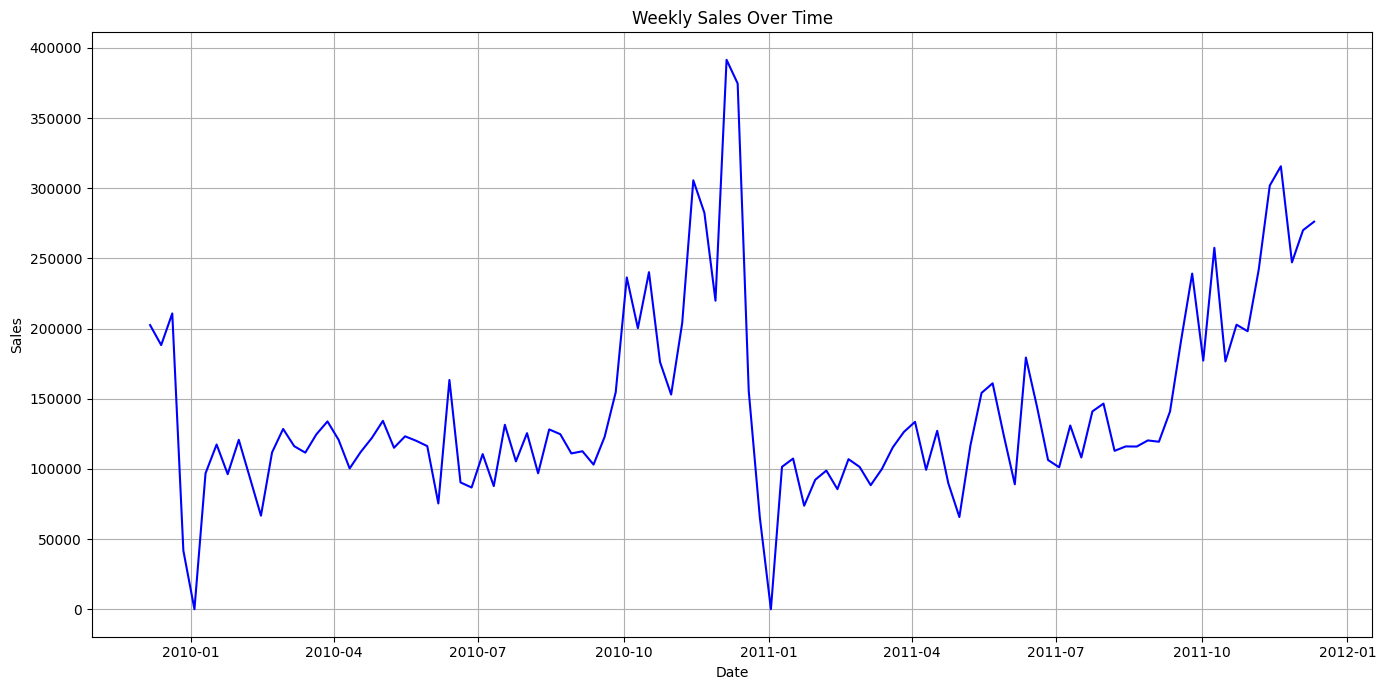

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(total_sales['ds'], total_sales['y'], color='blue', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Weekly Sales Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# change data format to be used in Chronos
total_sales_chronos = total_sales.rename(columns={'ds': 'timestamp', 'y': 'target'})
total_sales_chronos['item_id'] = 1
print(total_sales_chronos.head())

   timestamp     target  item_id
0 2009-12-06  202466.59        1
1 2009-12-13  188216.38        1
2 2009-12-20  210772.80        1
3 2009-12-27   41782.86        1
4 2010-01-03       0.00        1


In [ ]:
total_sales_chronos = TimeSeriesDataFrame.from_data_frame(total_sales_chronos)
print(total_sales_chronos.head())
total_sales_chronos.describe()

                       target
item_id timestamp            
1       2009-12-06  202466.59
        2009-12-13  188216.38
        2009-12-20  210772.80
        2009-12-27   41782.86
        2010-01-03       0.00


,target
count,106.000000
mean,143367.106698
std,69026.453653
min,0.000000
25%,101869.295000
50%,121385.520000
75%,172897.837500
max,391471.270000


# without product categorization

## Chronos zero-shot model

### Chronos zero-shot bolt_tiny:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="W").fit(
    train_data, presets="bolt_tiny",
)

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_202428'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.07 GB / 12.67 GB (79.4%)
Disk Space Avail:   63.74 GB / 107.72 GB (59.2%)
Setting presets to: bolt_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 21,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_tiny]


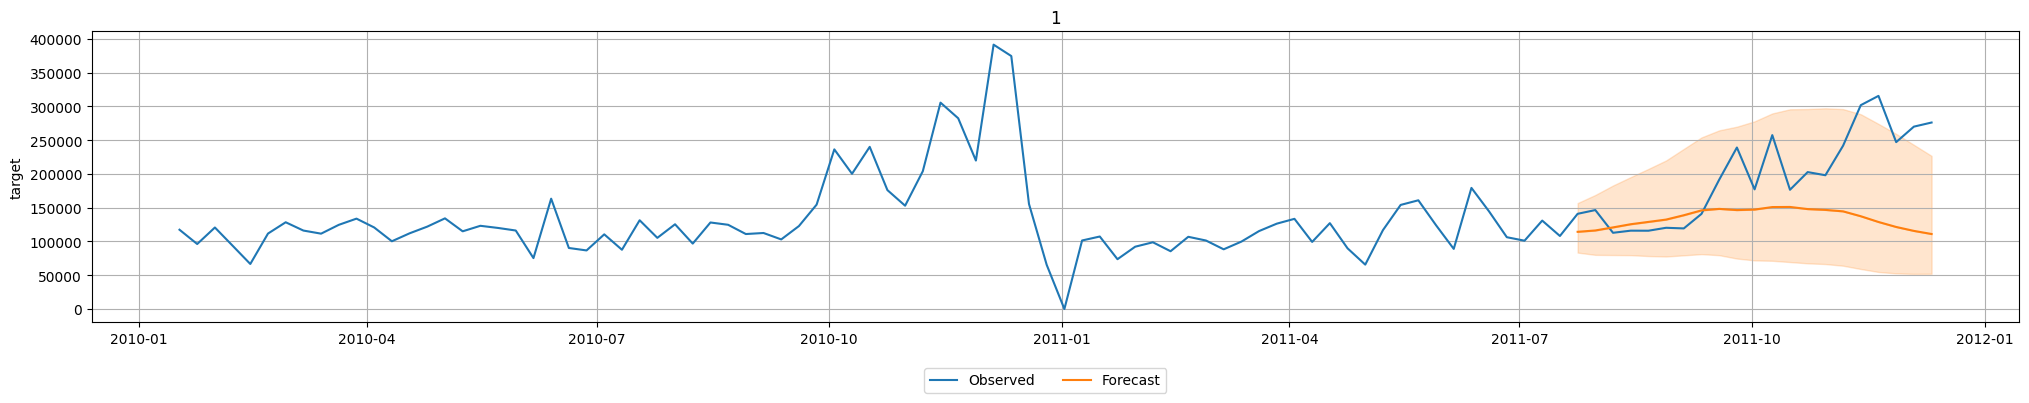

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=100,
);

In [ ]:
print(predictions.shape)
predictions.head()

(21, 10)


mean           0.1           0.2            0.3  \
item_id timestamp                                                              
1       2011-07-24  114327.398438  83531.023438  95085.484375  102759.757812   
        2011-07-31  116308.078125  80195.734375  93565.296875  102403.437500   
        2011-08-07  120850.664062  79942.328125  94794.945312  104662.171875   
        2011-08-14  125549.523438  79744.671875  96121.765625  107153.351562   
        2011-08-21  128976.343750  78433.085938  96127.390625  108572.335938   

                              0.4            0.5            0.6  \
item_id timestamp                                                 
1       2011-07-24  108811.468750  114327.398438  120076.179688   
        2011-07-31  109640.296875  116308.078125  123355.875000   
        2011-08-07  113086.257812  120850.664062  129156.437500   
        2011-08-14  116692.617188  125549.523438  134979.062500   
        2011-08-21  118981.609375  128976.343750  139671.875000   

                              0.7            0.8            0.9  
item_id timestamp                                                
1       2011-07-24  127181.250000  137086.359375  156852.781250  
        2011-07-31  132111.265625  144178.765625  168889.140625  
        2011-08-07  139385.203125  153884.031250  182894.250000  
        2011-08-14  146521.562500  162750.000000  195315.203125  
        2011-08-21  152650.703125  170958.062500  207478.906250

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_tiny],-0.255041,None,1.755713,None,0.021355,1,-0.255041,-67700.545818,-8.082694e+09,-89903.802827,-0.287973


Overall MAPE for Test Period 1: 13.22%
Overall MAPE for Test Period 2: 23.53%
Overall MAPE for Test Period 3: 49.65%


<Figure size 640x480 with 0 Axes>

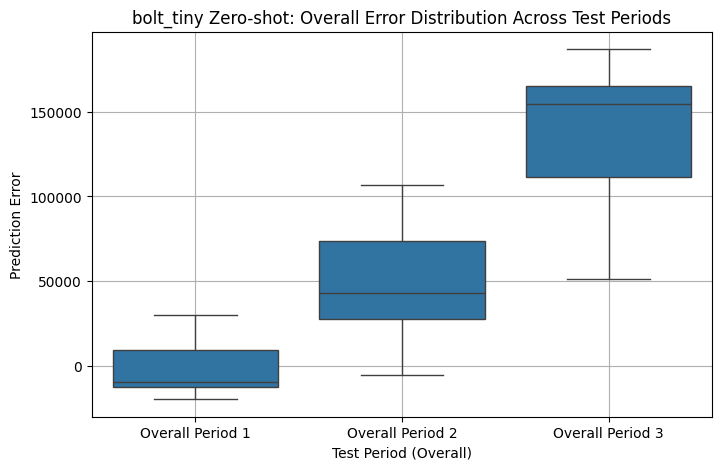

In [ ]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

three_split_plot(predictions, 'bolt_tiny Zero-shot')

### Chronos zero-shot bolt_mini:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="W").fit(
    train_data, presets="bolt_mini",
)

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_202714'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.03 GB / 12.67 GB (79.1%)
Disk Space Avail:   63.74 GB / 107.72 GB (59.2%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 21,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

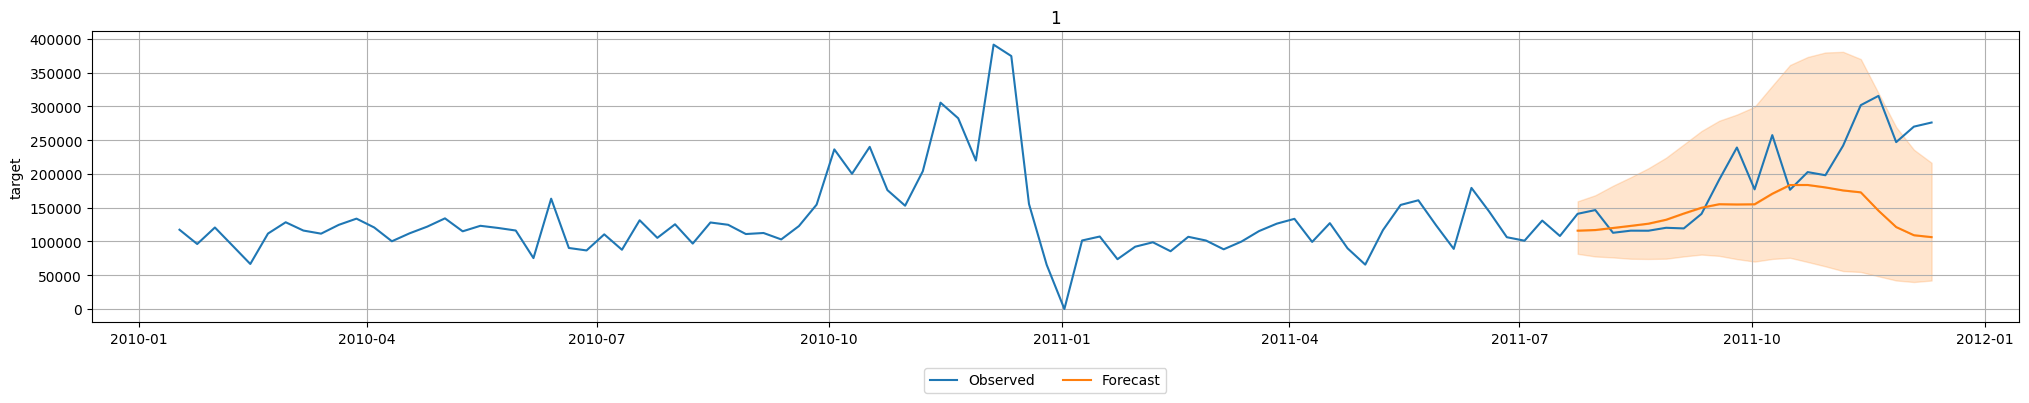

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=100,
);

In [ ]:
print(predictions.shape)
predictions.head()

(21, 10)


mean           0.1           0.2            0.3  \
item_id timestamp                                                              
1       2011-07-24  116031.898438  81712.375000  95727.281250  104311.781250   
        2011-07-31  116966.335938  77793.015625  93784.343750  103294.398438   
        2011-08-07  120025.039062  76379.718750  93441.679688  104239.468750   
        2011-08-14  123119.781250  74425.578125  92810.429688  104931.703125   
        2011-08-21  126373.367188  74109.828125  93600.890625  106265.343750   

                              0.4            0.5            0.6  \
item_id timestamp                                                 
1       2011-07-24  110860.304688  116031.898438  121361.656250   
        2011-07-31  110843.421875  116966.335938  123174.242188   
        2011-08-07  112744.929688  120025.039062  127844.757812   
        2011-08-14  114364.937500  123119.781250  131703.484375   
        2011-08-21  116922.468750  126373.367188  136621.093750   

                              0.7           0.8            0.9  
item_id timestamp                                               
1       2011-07-24  127983.625000  138272.93750  159474.593750  
        2011-07-31  131136.171875  142962.37500  168484.562500  
        2011-08-07  137258.250000  151525.46875  182545.687500  
        2011-08-14  142882.796875  159805.71875  195099.875000  
        2011-08-21  149158.000000  168798.62500  208445.796875

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_mini],-0.231314,None,4.739364,None,0.031349,1,-0.231314,-57974.717024,-6.667676e+09,-81655.837946,-0.244255


Overall MAPE for Test Period 1: 12.53%
Overall MAPE for Test Period 2: 17.18%
Overall MAPE for Test Period 3: 43.57%


<Figure size 640x480 with 0 Axes>

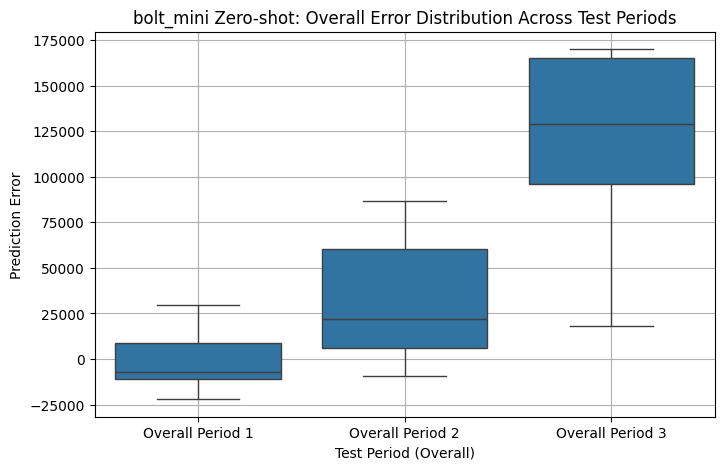

In [ ]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

three_split_plot(predictions, 'bolt_mini Zero-shot')

### Chronos zero-shot bolt_small:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="W").fit(
    train_data, presets="bolt_small",
)

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_202819'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.06 GB / 12.67 GB (79.4%)
Disk Space Avail:   63.66 GB / 107.72 GB (59.1%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 21,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

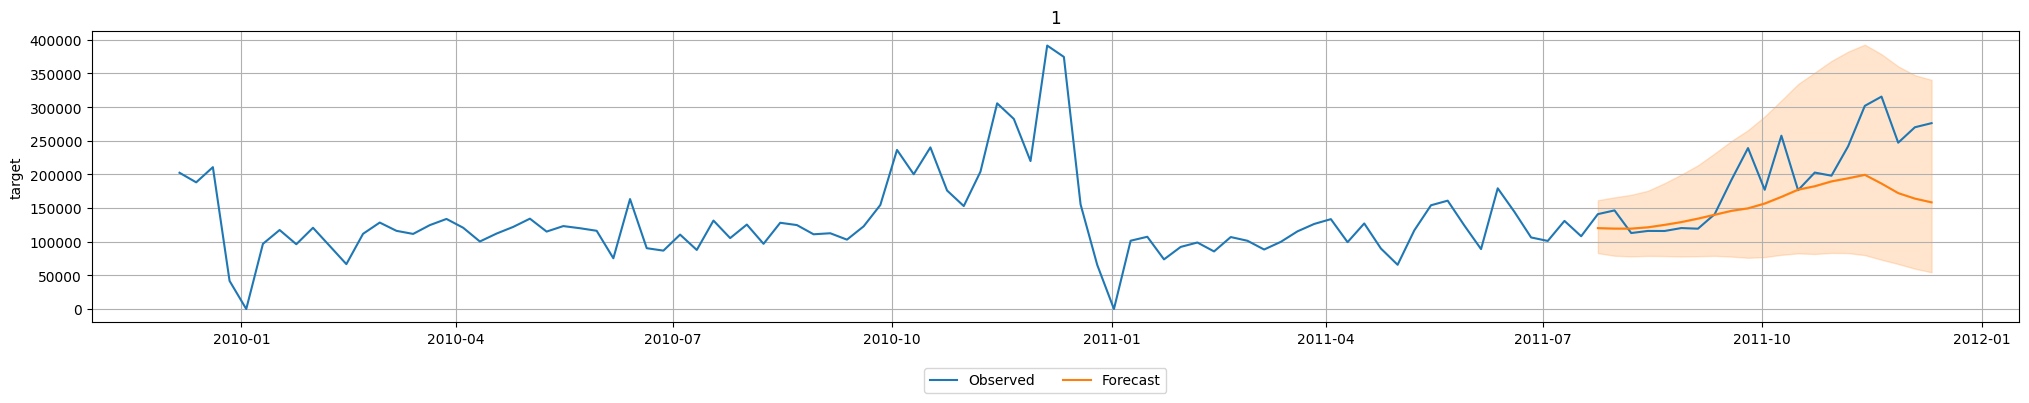

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
print(predictions.shape)
predictions.head()

(21, 10)


mean           0.1           0.2            0.3  \
item_id timestamp                                                              
1       2011-07-24  120226.359375  83043.718750  96551.921875  105721.265625   
        2011-07-31  119537.695312  79140.054688  93878.453125  103627.828125   
        2011-08-07  119505.570312  78238.125000  93117.328125  103338.804688   
        2011-08-14  121457.695312  78939.078125  94110.093750  104565.492188   
        2011-08-21  125070.140625  78701.671875  94882.171875  106418.304688   

                              0.4            0.5            0.6  \
item_id timestamp                                                 
1       2011-07-24  113280.929688  120226.359375  127001.546875   
        2011-07-31  111978.273438  119537.695312  127023.085938   
        2011-08-07  111755.500000  119505.570312  127212.851562   
        2011-08-14  113259.398438  121457.695312  129657.671875   
        2011-08-21  116110.390625  125070.140625  134108.234375   

                              0.7            0.8            0.9  
item_id timestamp                                                
1       2011-07-24  134477.593750  143730.437500  161610.937500  
        2011-07-31  135194.812500  145805.625000  165952.765625  
        2011-08-07  135560.609375  146494.125000  169667.218750  
        2011-08-14  138347.062500  149968.093750  175691.656250  
        2011-08-21  143956.218750  157203.046875  187000.906250

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_small],-0.176929,None,3.302455,None,0.007344,1,-0.176929,-45107.631652,-3.857311e+09,-62107.252031,-0.191217


Overall MAPE for Test Period 1: 10.22%
Overall MAPE for Test Period 2: 17.01%
Overall MAPE for Test Period 3: 30.13%


<Figure size 640x480 with 0 Axes>

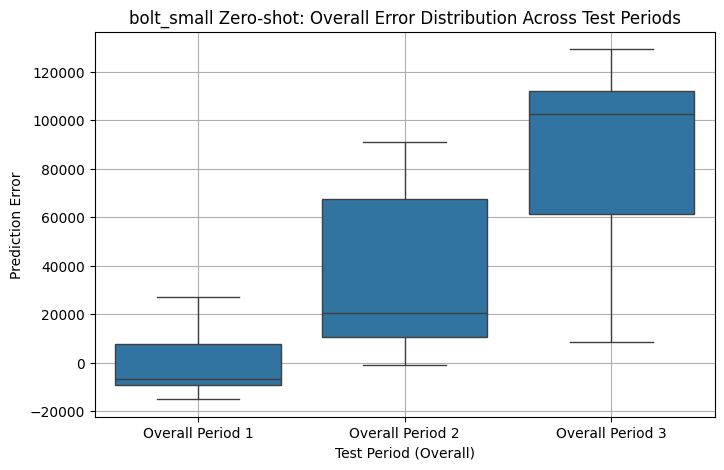

In [ ]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

three_split_plot(predictions, 'bolt_small Zero-shot')

### Chronos zero-shot bolt_base:

In [ ]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="W").fit(
    train_data, presets="bolt_base",
)

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_202926'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.03 GB / 12.67 GB (79.1%)
Disk Space Avail:   63.49 GB / 107.72 GB (58.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 21,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

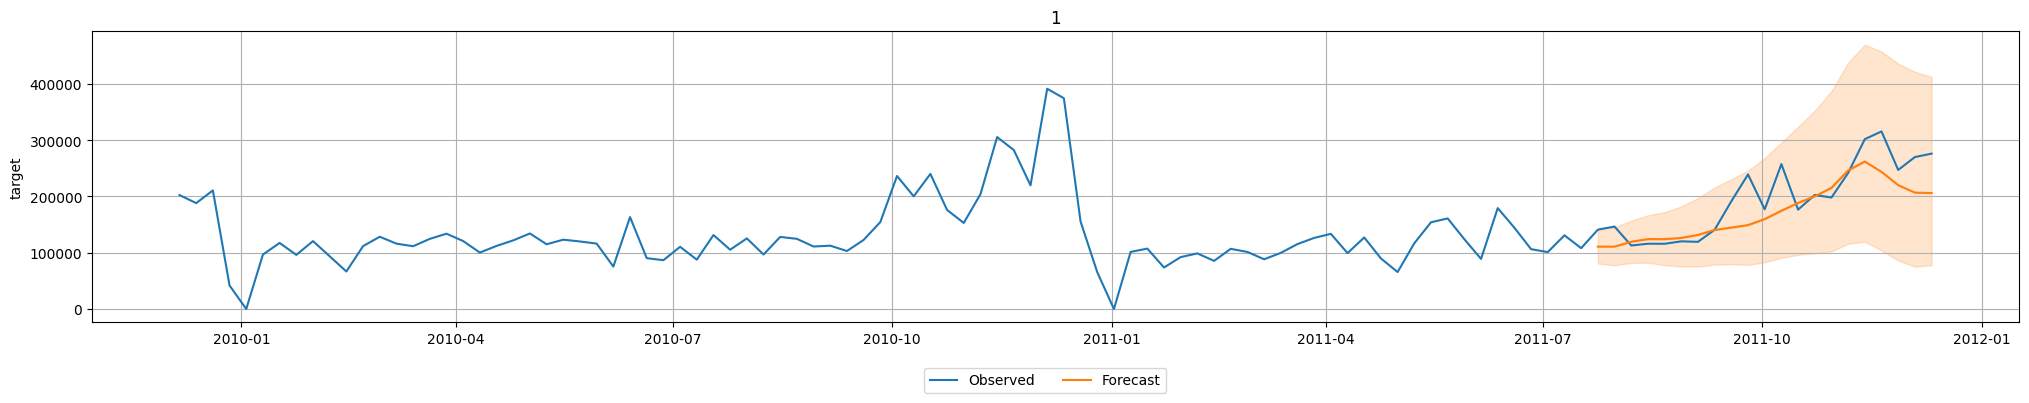

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
print(predictions.shape)
predictions.head()

(21, 10)


mean           0.1           0.2            0.3  \
item_id timestamp                                                              
1       2011-07-24  110906.554688  80920.156250  93150.078125  100487.015625   
        2011-07-31  110937.960938  77614.031250  92061.445312  100446.390625   
        2011-08-07  119563.406250  81814.937500  98329.046875  107502.804688   
        2011-08-14  124251.562500  82417.289062  99793.718750  110292.468750   
        2011-08-21  124194.773438  77977.968750  96511.328125  107889.656250   

                              0.4            0.5            0.6  \
item_id timestamp                                                 
1       2011-07-24  106037.523438  110906.554688  116012.921875   
        2011-07-31  106360.773438  110937.960938  115807.593750   
        2011-08-07  114227.250000  119563.406250  124833.976562   
        2011-08-14  117889.898438  124251.562500  130775.179688   
        2011-08-21  116536.671875  124194.773438  131558.218750   

                              0.7            0.8            0.9  
item_id timestamp                                                
1       2011-07-24  122072.773438  130125.046875  143785.375000  
        2011-07-31  121760.203125  129917.468750  145313.078125  
        2011-08-07  131092.218750  140305.281250  156894.031250  
        2011-08-14  137827.625000  148028.250000  166519.968750  
        2011-08-21  139812.500000  151274.250000  172086.625000

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_base],-0.143164,None,8.027495,None,0.006981,1,-0.143164,-31080.090193,-1.753448e+09,-41874.193783,-0.142683


Overall MAPE for Test Period 1: 11.59%
Overall MAPE for Test Period 2: 16.04%
Overall MAPE for Test Period 3: 15.18%


<Figure size 640x480 with 0 Axes>

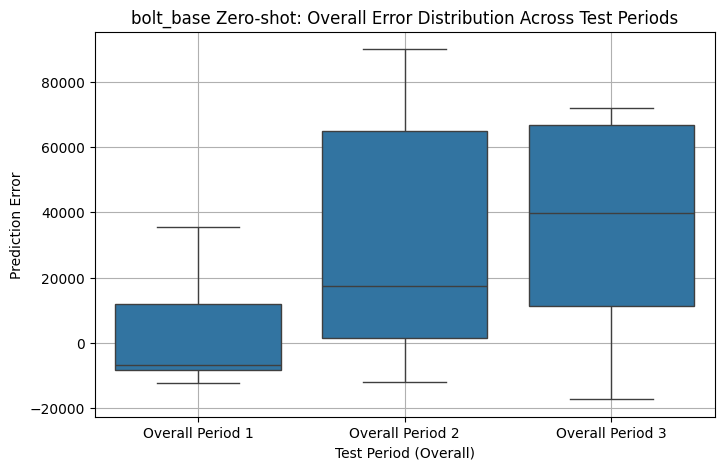

In [ ]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

three_split_plot(predictions, 'bolt_base Zero-shot')

## Chronos fine-tuned model

### Chronos fine tune bolt_tiny

#### manually set hyperparameters tuning

In [ ]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_tiny", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_tiny", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_212011'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.66 GB / 12.67 GB (76.2%)
Disk Space Avail:   59.18 GB / 107.72 GB (54.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_tiny]/T4,-0.233403,-0.198316,0.854711,0.023225,29.403805,5,-0.233403,-59748.014955,-6.363454e+09,-79771.258291,-0.287853
1,ChronosFineTuned[bolt_tiny]/T1,-0.247639,-0.189878,0.683349,0.022764,27.881258,2,-0.247639,-66277.844554,-7.730887e+09,-87925.462938,-0.285000
2,ChronosZeroShot[bolt_tiny],-0.255041,-0.189754,1.298844,1.662697,0.017431,1,-0.255041,-67700.545818,-8.082694e+09,-89903.802827,-0.287973
3,ChronosFineTuned[bolt_tiny]/T2,-0.257572,-0.249422,0.837591,0.023206,27.790755,3,-0.257572,-63902.418408,-7.038980e+09,-83898.626584,-0.335647
4,ChronosFineTuned[bolt_tiny]/T8,-0.266111,-0.178586,0.813463,0.035799,34.321238,9,-0.266111,-70990.179762,-7.159719e+09,-84615.122994,-0.371503
5,ChronosFineTuned[bolt_tiny]/T6,-0.271601,-0.979761,0.637796,0.023540,177.905107,7,-0.271601,-63979.336830,-8.948513e+09,-94596.579189,-0.315198
6,WeightedEnsemble,-0.278562,-0.164461,0.666724,0.022467,1.321913,11,-0.278562,-74247.370610,-7.810700e+09,-88378.166410,-0.389109
7,ChronosFineTuned[bolt_tiny]/T5,-0.278562,-0.164461,0.663005,0.022467,51.289680,6,-0.278562,-74247.370610,-7.810700e+09,-88378.166410,-0.389109
8,ChronosFineTuned[bolt_tiny]/T7,-0.290340,-0.170441,0.779282,0.026077,51.312831,8,-0.290340,-73094.685164,-8.558581e+09,-92512.600358,-0.388371
9,ChronosFineTuned[bolt_tiny]/T9,-0.348990,-1.086502,0.823527,0.022549,64.870232,10,-0.348990,-83329.580238,-1.334311e+10,-115512.388735,-0.408252


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_tiny]/T5


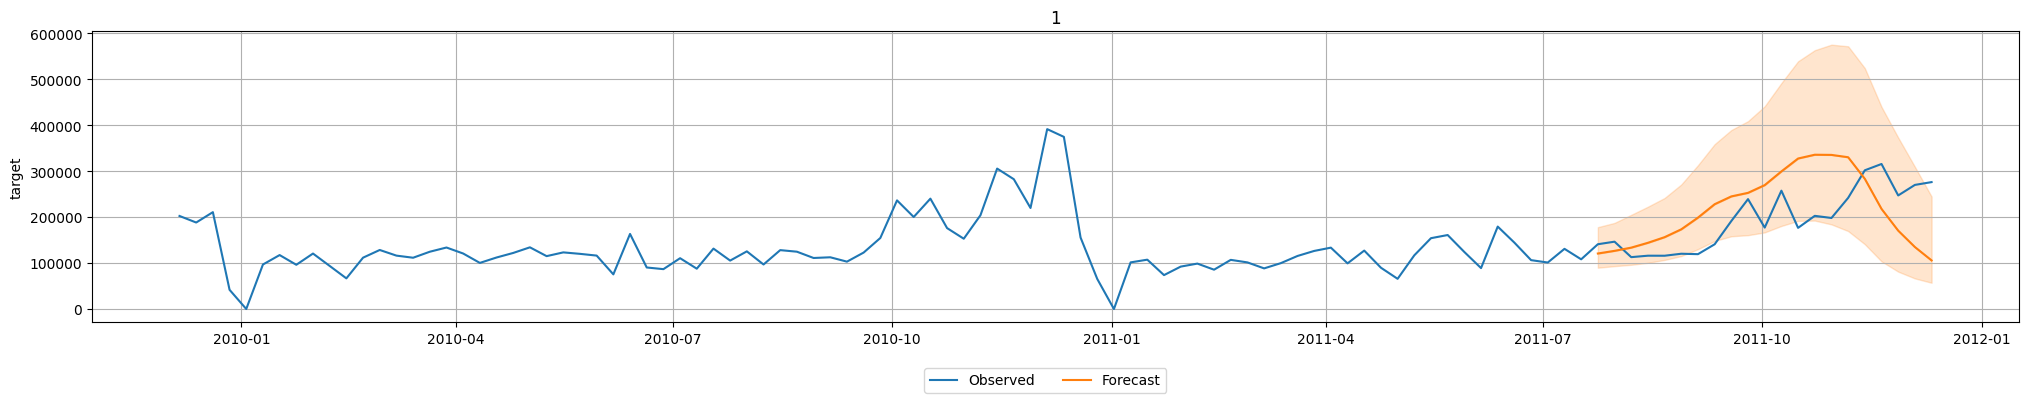

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 30.88%
Overall MAPE for Test Period 2: 45.02%
Overall MAPE for Test Period 3: 40.83%


<Figure size 640x480 with 0 Axes>

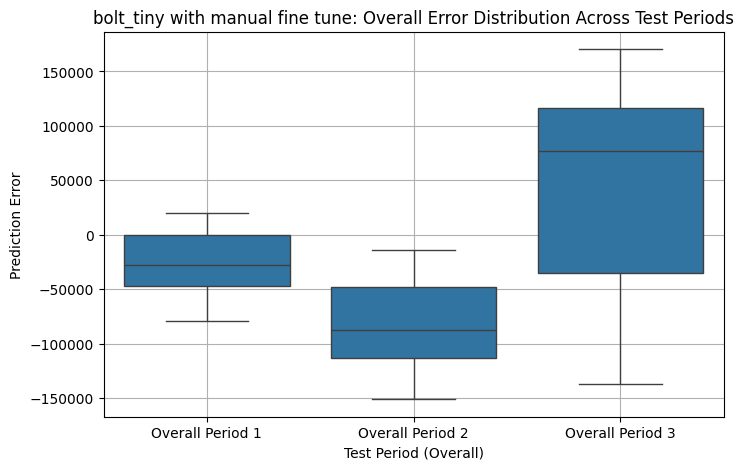

In [ ]:
three_split_plot(predictions, 'bolt_tiny with manual fine tune')

### Chronos fine tune bolt_mini


#### manually set hyperparameters tuning

In [ ]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_mini", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_mini", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_205148'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.56 GB / 12.67 GB (75.4%)
Disk Space Avail:   61.76 GB / 107.72 GB (57.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_mini]/T1,-0.224502,-0.192945,0.733430,0.037281,51.633342,2,-0.224502,-56303.975208,-6.290641e+09,-79313.562188,-0.240416
1,ChronosZeroShot[bolt_mini],-0.231314,-0.200453,1.341398,1.358992,0.020297,1,-0.231314,-57974.717024,-6.667676e+09,-81655.837946,-0.244255
2,ChronosFineTuned[bolt_mini]/T4,-0.236435,-0.167172,0.750016,0.032610,52.661809,5,-0.236435,-60652.107158,-6.025619e+09,-77624.862499,-0.300629
3,WeightedEnsemble,-0.238168,-0.143812,1.677475,0.071446,0.944234,8,-0.238168,-59798.853676,-6.119169e+09,-78225.120467,-0.314618
4,ChronosFineTuned[bolt_mini]/T6,-0.244732,-0.616864,0.712500,0.033786,83.159479,7,-0.244732,-66378.111131,-7.615763e+09,-87268.337682,-0.307180
5,ChronosFineTuned[bolt_mini]/T2,-0.257628,-0.146699,0.921812,0.038836,51.089172,3,-0.257628,-62118.772530,-7.309514e+09,-85495.693915,-0.326584
6,ChronosFineTuned[bolt_mini]/T3,-0.333693,-0.393509,0.738909,0.031365,246.982380,4,-0.333693,-78050.997649,-1.168470e+10,-108095.810349,-0.394077
7,ChronosFineTuned[bolt_mini]/T5,-0.353409,-0.162032,0.719930,0.036676,97.898021,6,-0.353409,-90341.662842,-1.273076e+10,-112830.674643,-0.470538


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


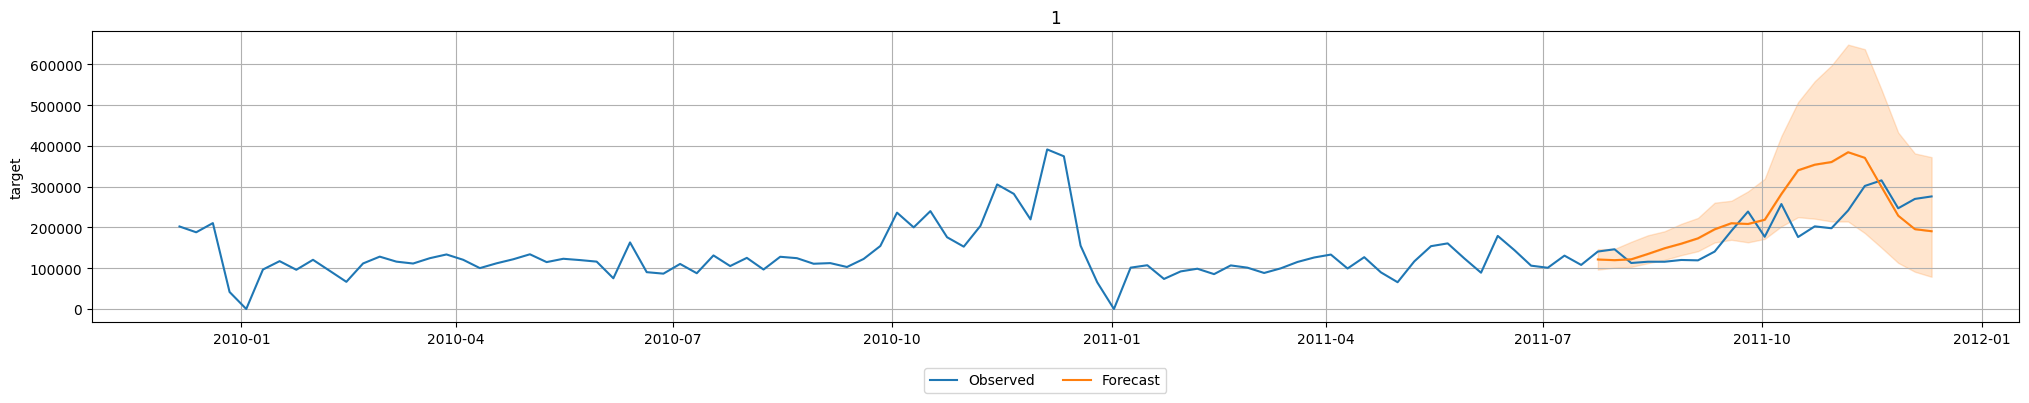

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 23.39%
Overall MAPE for Test Period 2: 37.45%
Overall MAPE for Test Period 3: 33.55%


<Figure size 640x480 with 0 Axes>

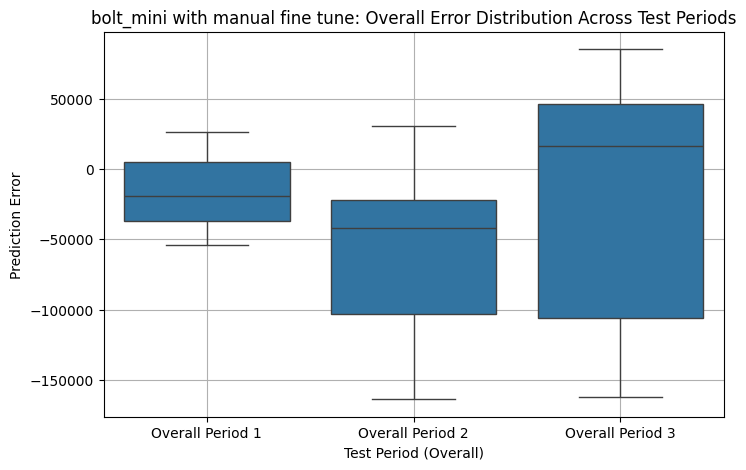

In [ ]:
three_split_plot(predictions, 'bolt_mini with manual fine tune')

### Chronos fine tune bolt_small

#### manually set hyperparameters tuning

In [ ]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, eval_metric="MAPE").fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_small", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1000,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1000s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_210305'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.90 GB / 12.67 GB (78.1%)
Disk Space Avail:   61.31 GB / 107.72 GB (56.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fin

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_small]/T2,-0.175394,-0.236352,0.943323,0.102896,110.218046,3,-0.144587,-33369.893765,-2.070706e+09,-45505.015870,-0.175394
1,ChronosFineTuned[bolt_small]/T1,-0.187366,-0.190960,1.288892,0.057198,124.121541,2,-0.171501,-43450.093512,-3.540592e+09,-59502.875828,-0.187366
2,WeightedEnsemble,-0.191217,-0.184121,1.482334,2.650270,0.463134,5,-0.176929,-45107.631652,-3.857311e+09,-62107.252031,-0.191217
3,ChronosZeroShot[bolt_small],-0.191217,-0.184121,1.477338,2.650270,0.031163,1,-0.176929,-45107.631652,-3.857311e+09,-62107.252031,-0.191217
4,ChronosFineTuned[bolt_small]/T3,-0.374362,-0.397713,1.129540,0.062744,214.355777,4,-0.320384,-75824.599286,-1.004521e+10,-100225.819509,-0.374362


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[bolt_small]


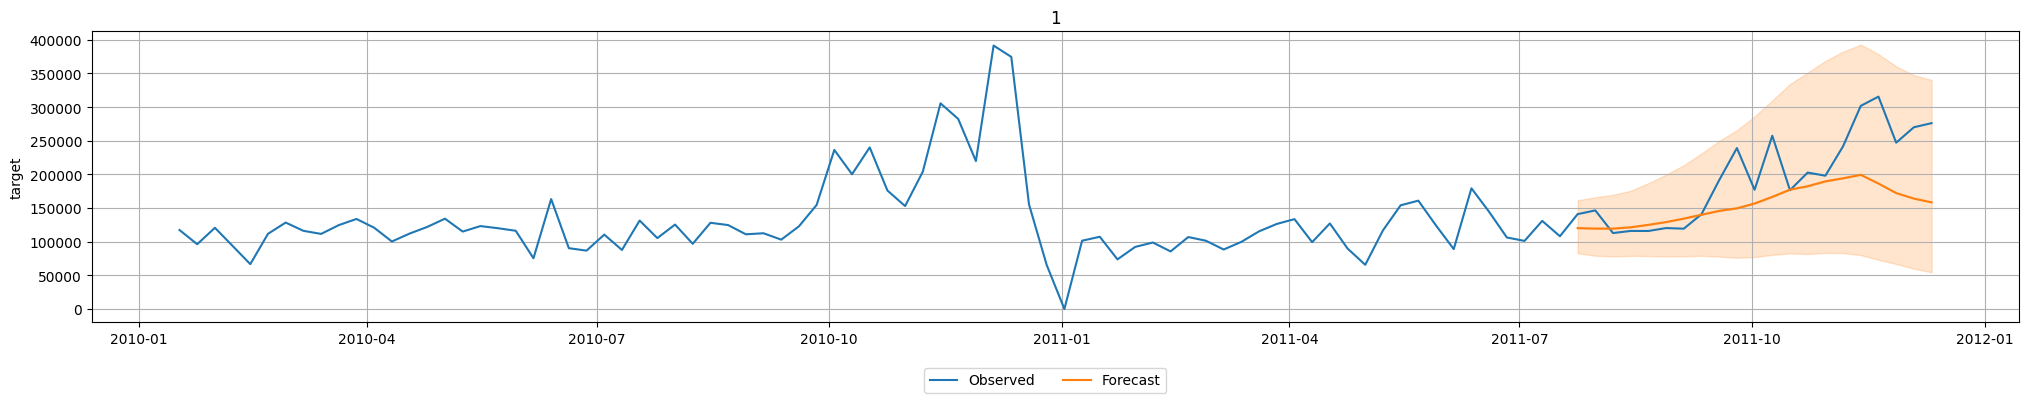

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=100,
);

Overall MAPE for Test Period 1: 10.22%
Overall MAPE for Test Period 2: 17.01%
Overall MAPE for Test Period 3: 30.13%


<Figure size 640x480 with 0 Axes>

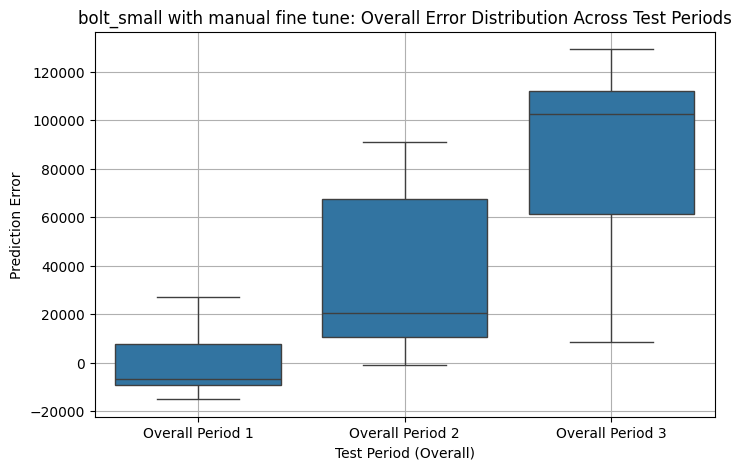

In [ ]:
three_split_plot(predictions, 'bolt_small with manual fine tune')

### Chronos fine tune bolt_base

#### manually set hyperparameters tuning

In [ ]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_base", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250410_211151'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250410
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.87 GB / 12.67 GB (77.9%)
Disk Space Avail:   60.63 GB / 107.72 GB (56.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_base]/T1,-0.137780,-0.254915,2.336424,0.134181,455.622385,2,-0.137780,-30870.534405,-1.502094e+09,-38756.860333,-0.148481
1,WeightedEnsemble,-0.141752,-0.253514,4.078367,1.781239,0.365356,3,-0.141752,-30867.212768,-1.693286e+09,-41149.555099,-0.142985
2,ChronosZeroShot[bolt_base],-0.143164,-0.253631,1.736331,1.647058,0.023409,1,-0.143164,-31080.090193,-1.753448e+09,-41874.193783,-0.142683


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


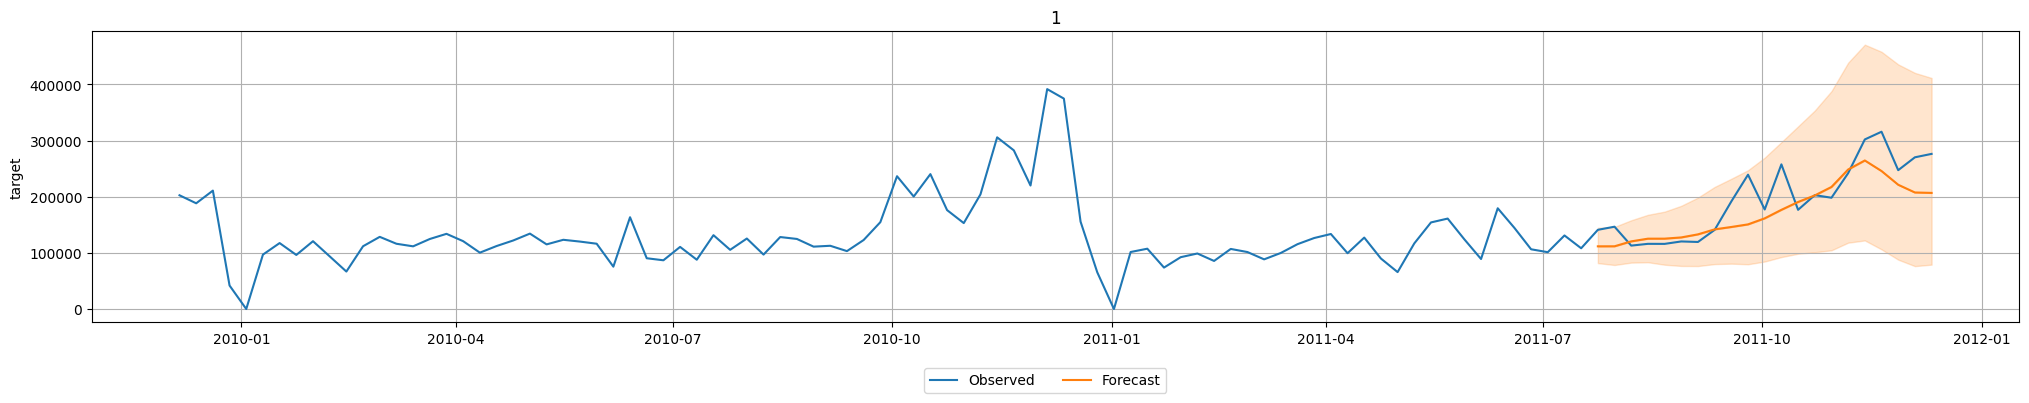

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 12.08%
Overall MAPE for Test Period 2: 15.70%
Overall MAPE for Test Period 3: 15.11%


<Figure size 640x480 with 0 Axes>

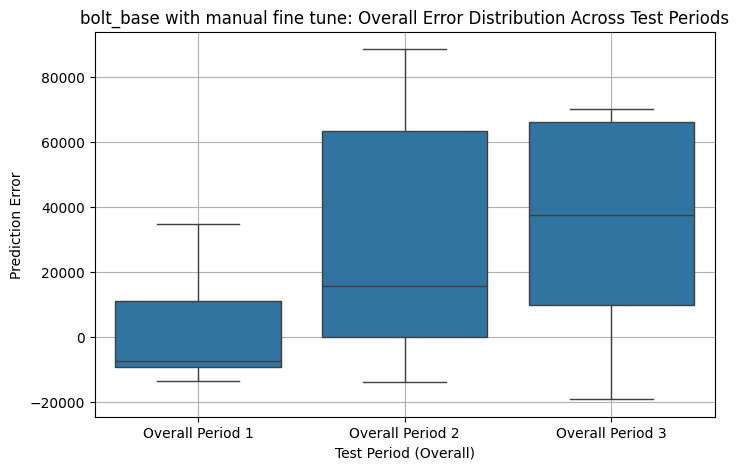

In [ ]:
three_split_plot(predictions, 'bolt_base with manual fine tune')

m

#### different manually set hyperparameters tuning

In [ ]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, eval_metric = 'MAPE').fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_base", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.0001, 0.0005, log=True),
                 "fine_tune_steps": space.Categorical(10, 20),
                 "fine_tune_batch_size": space.Categorical(4, 8, 12),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_213147'
=================== System Info ===================
AutoGluon Version:  1.2.1b20250425
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       9.01 GB / 12.67 GB (71.1%)
Disk Space Avail:   32.92 GB / 107.72 GB (30.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosZeroShot[bolt_base],-0.142683,-0.312829,1.121697,1.479556,0.014387,1,-0.143164,-31080.084613,-1.753447e+09,-41874.186126,-0.142683
1,ChronosFineTuned[bolt_base]/T9,-0.174108,-0.312307,4.683312,0.111638,26.982571,10,-0.162127,-39638.523586,-2.883930e+09,-53702.233608,-0.174108
2,ChronosFineTuned[bolt_base]/T11,-0.175978,-0.201166,4.614405,0.111302,49.242517,12,-0.152309,-35549.263185,-2.024225e+09,-44991.384967,-0.175978
3,ChronosFineTuned[bolt_base]/T2,-0.191097,-0.293769,4.531532,0.116273,31.472568,3,-0.161850,-40475.426696,-2.714610e+09,-52101.918028,-0.191097
4,ChronosFineTuned[bolt_base]/T8,-0.208392,-0.370348,4.516965,0.124722,32.730107,9,-0.161903,-40130.263824,-2.524110e+09,-50240.525066,-0.208392
5,ChronosFineTuned[bolt_base]/T1,-0.208631,-0.277716,4.658205,0.118905,32.676535,2,-0.158878,-38493.783914,-2.084365e+09,-45654.842591,-0.208631
6,ChronosFineTuned[bolt_base]/T13,-0.213376,-0.302401,4.598618,0.120746,35.928055,14,-0.171204,-42450.765015,-3.043780e+09,-55170.466624,-0.213376
7,ChronosFineTuned[bolt_base]/T4,-0.216477,-0.258767,4.538018,0.130970,33.786300,5,-0.167051,-41882.055982,-2.651126e+09,-51489.083523,-0.216477
8,ChronosFineTuned[bolt_base]/T3,-0.219745,-0.302078,4.370491,0.133200,31.366672,4,-0.177514,-44228.528780,-3.388293e+09,-58209.049468,-0.219745
9,ChronosFineTuned[bolt_base]/T10,-0.282393,-0.321552,4.554067,0.114289,32.868490,11,-0.229193,-58616.492262,-5.872225e+09,-76630.444709,-0.282393


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


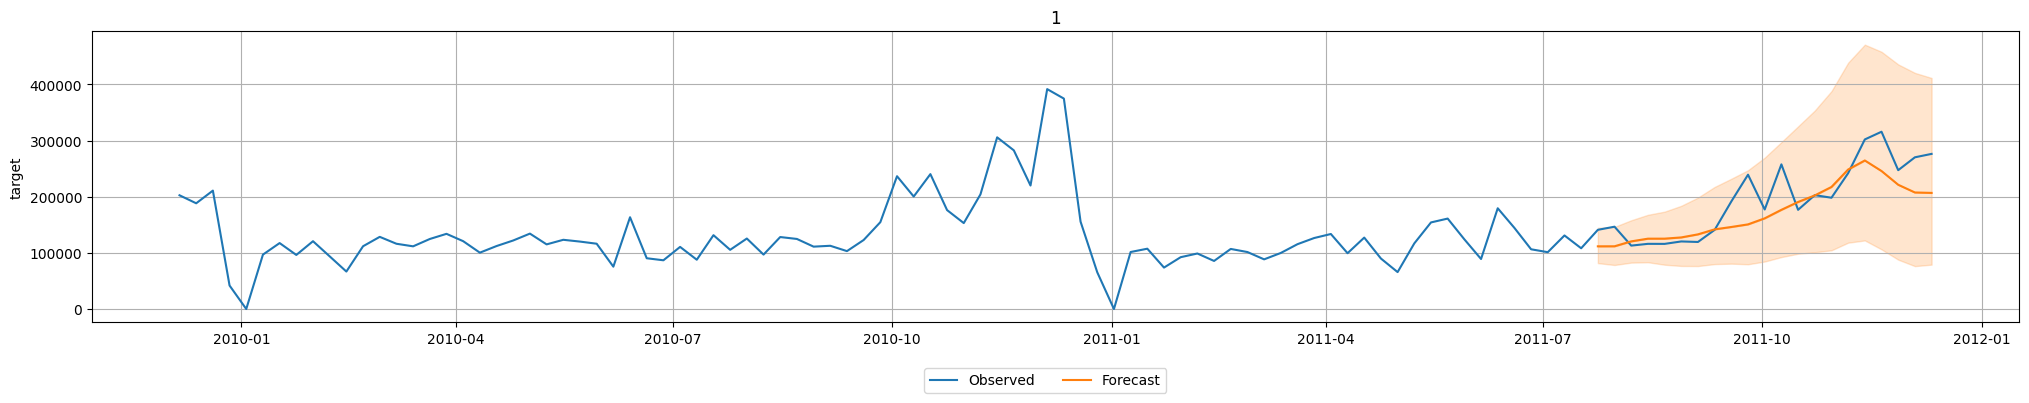

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [ ]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

Overall MAPE for Test Period 1: 12.08%
Overall MAPE for Test Period 2: 15.70%
Overall MAPE for Test Period 3: 15.11%


<Figure size 640x480 with 0 Axes>

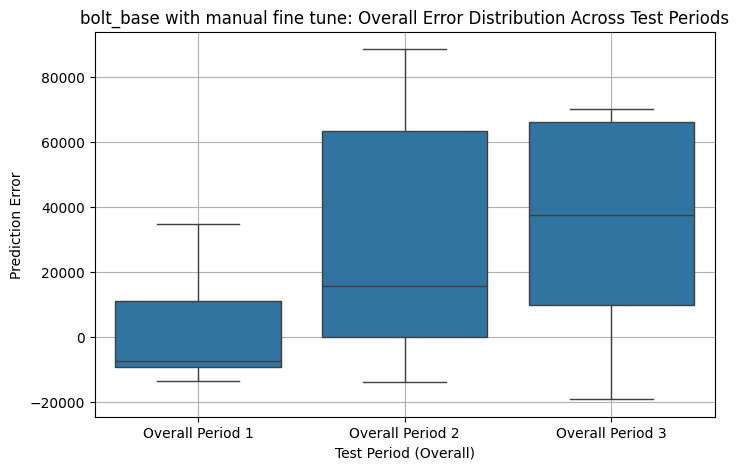

In [ ]:
three_split_plot(predictions, 'bolt_base with manual fine tune')